In [1]:
#!pip install torch

# !jupyter notebook \
#     --NotebookApp.allow_origin='https://colab.research.google.com' \
#     --port=8888 \
#     --NotebookApp.port_retries=0

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import math
import torch
import datetime
import tensorflow
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.optimizers import SGD, Adam
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from keras import layers, Sequential, callbacks
from sklearn.metrics import mean_squared_error
from keras import callbacks
from keras.optimizers.schedules import ExponentialDecay
from keras.layers import Conv2D, Flatten, Dense, LSTM, Dropout, GRU, Bidirectional, Conv1D, MaxPooling1D

import warnings
warnings.filterwarnings("ignore")

In [4]:
os.chdir('/content/drive/My Drive/Colab Notebooks/Traffic Prediction')
#!pip freeze > requirements.txt

In [5]:
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Traffic Prediction/traffic.csv')
data.head()

DateTime  Junction  Vehicles           ID
0  2015-11-01 00:00:00         1        15  20151101001
1  2015-11-01 01:00:00         1        13  20151101011
2  2015-11-01 02:00:00         1        10  20151101021
3  2015-11-01 03:00:00         1         7  20151101031
4  2015-11-01 04:00:00         1         9  20151101041

In [6]:
df_original = data.copy()
df = df_original.drop(columns = ['ID'], axis=1)
df

DateTime  Junction  Vehicles
0      2015-11-01 00:00:00         1        15
1      2015-11-01 01:00:00         1        13
2      2015-11-01 02:00:00         1        10
3      2015-11-01 03:00:00         1         7
4      2015-11-01 04:00:00         1         9
...                    ...       ...       ...
48115  2017-06-30 19:00:00         4        11
48116  2017-06-30 20:00:00         4        30
48117  2017-06-30 21:00:00         4        16
48118  2017-06-30 22:00:00         4        22
48119  2017-06-30 23:00:00         4        12

[48120 rows x 3 columns]

In [7]:
data['DateTime'] = pd.to_datetime(data['DateTime'])

data['Day'] = data['DateTime'].dt.day
data['Month'] = data['DateTime'].dt.month
data['Year'] = data['DateTime'].dt.year
data['Hour'] = data['DateTime'].dt.hour
data['Day_of_week'] = data['DateTime'].dt.strftime("%A")

data

DateTime  Junction  Vehicles           ID  Day  Month  Year  \
0     2015-11-01 00:00:00         1        15  20151101001    1     11  2015   
1     2015-11-01 01:00:00         1        13  20151101011    1     11  2015   
2     2015-11-01 02:00:00         1        10  20151101021    1     11  2015   
3     2015-11-01 03:00:00         1         7  20151101031    1     11  2015   
4     2015-11-01 04:00:00         1         9  20151101041    1     11  2015   
...                   ...       ...       ...          ...  ...    ...   ...   
48115 2017-06-30 19:00:00         4        11  20170630194   30      6  2017   
48116 2017-06-30 20:00:00         4        30  20170630204   30      6  2017   
48117 2017-06-30 21:00:00         4        16  20170630214   30      6  2017   
48118 2017-06-30 22:00:00         4        22  20170630224   30      6  2017   
48119 2017-06-30 23:00:00         4        12  20170630234   30      6  2017   

       Hour Day_of_week  
0         0      Sunday  
1         1      Sunday  
2         2      Sunday  
3         3      Sunday  
4         4      Sunday  
...     ...         ...  
48115    19      Friday  
48116    20      Friday  
48117    21      Friday  
48118    22      Friday  
48119    23      Friday  

[48120 rows x 9 columns]

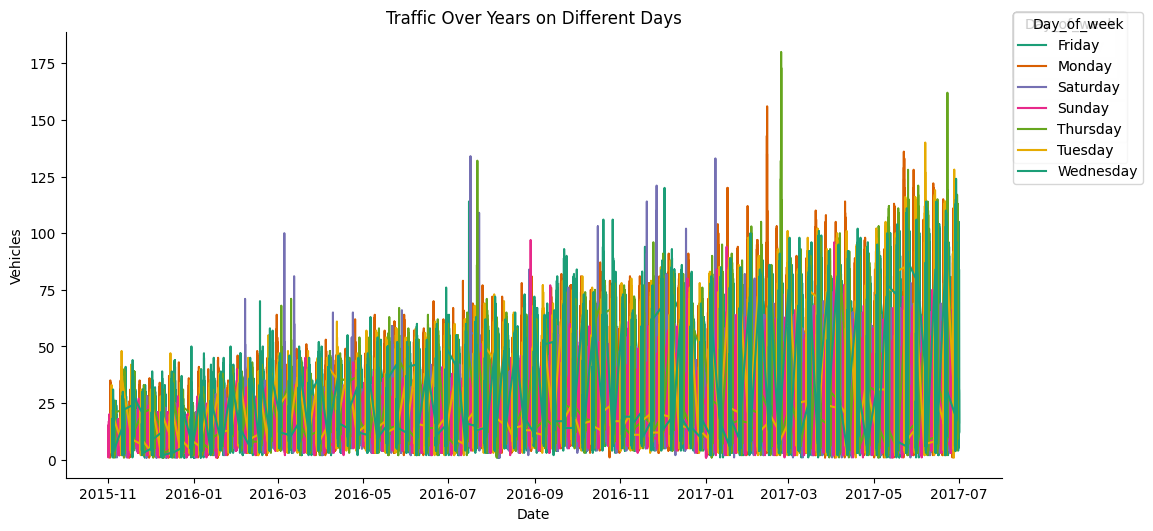

In [8]:
# @title DateTime vs Vehicles
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['DateTime']
  ys = series['Vehicles']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = data.sort_values('DateTime', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Day_of_week')):
  _plot_series(series, series_name, i)
  fig.legend(title='Day_of_week', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.title("Traffic Over Years on Different Days")
plt.xlabel('Date')
_ = plt.ylabel('Vehicles')

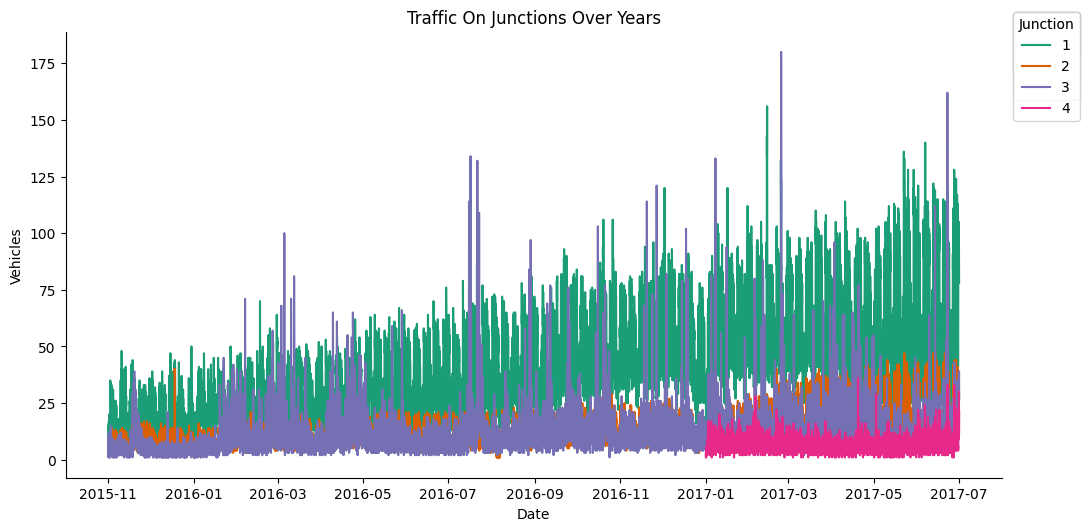

In [9]:
fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = data.sort_values('DateTime', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Junction')):
  _plot_series(series, series_name, i)
  fig.legend(title='Junction', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.title("Traffic On Junctions Over Years")
plt.xlabel('Date')
_ = plt.ylabel('Vehicles')

##### Plotting the newly created features

<Axes: xlabel='Day', ylabel='Vehicles'>

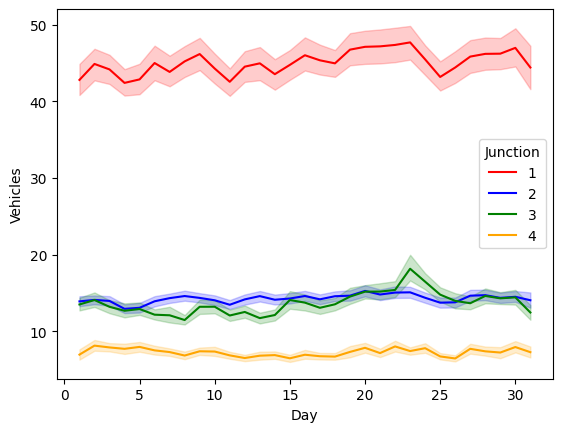

In [10]:
custom_palette = {1: 'red', 2: 'blue', 3: 'green', 4: 'orange'}
sns.lineplot(x=data['Day'], y="Vehicles", data=data, hue='Junction', palette=custom_palette)

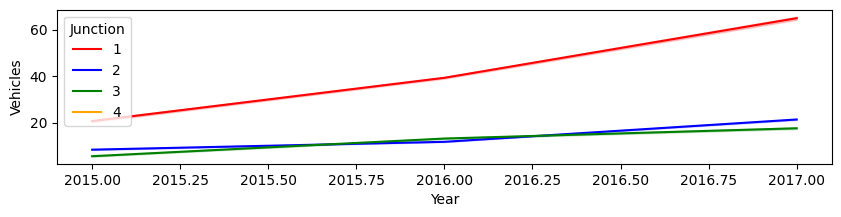

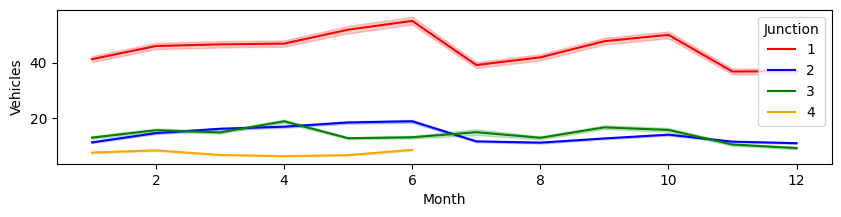

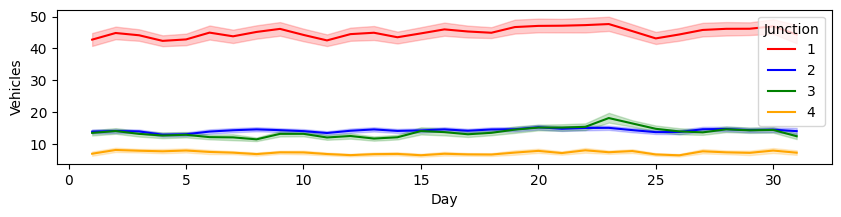

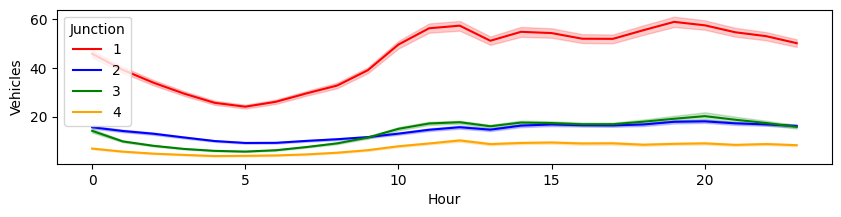

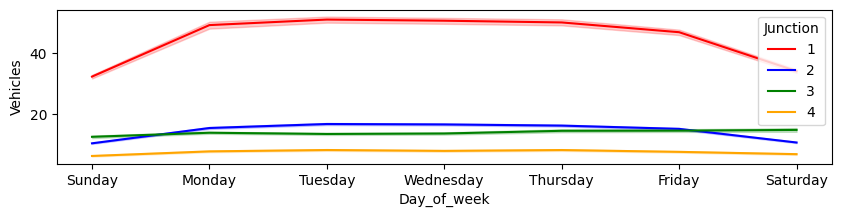

In [11]:
new_features = [ "Year","Month", "Day", "Hour", "Day_of_week"]

for feature in new_features:
  plt.figure(figsize=(10,2))
  ax = sns.lineplot(x=data[feature], y='Vehicles', data=data, hue='Junction',palette=custom_palette)


Text(0.5, 0, 'Date')

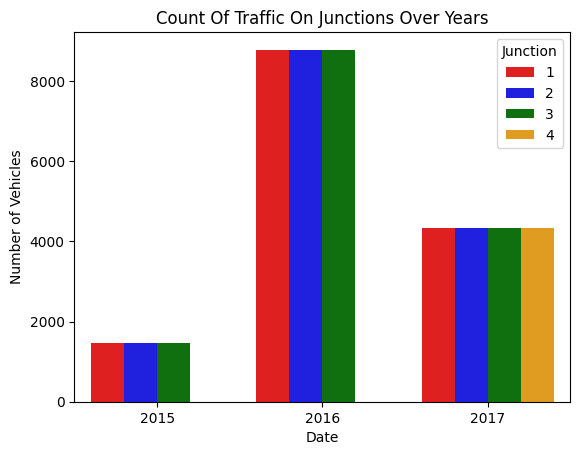

In [12]:
count = sns.countplot(data=data, x =data["Year"], hue="Junction", palette=custom_palette)
count.set_title("Count Of Traffic On Junctions Over Years")
count.set_ylabel("Number of Vehicles")
count.set_xlabel("Date")

The count plot shows an increase in the number of vehicles from 2015 to 2016. The same conclusion cannot be obejectively made about 2017 as there are limited data for 2017. The dataset contains up to only the 7th month for 2017.


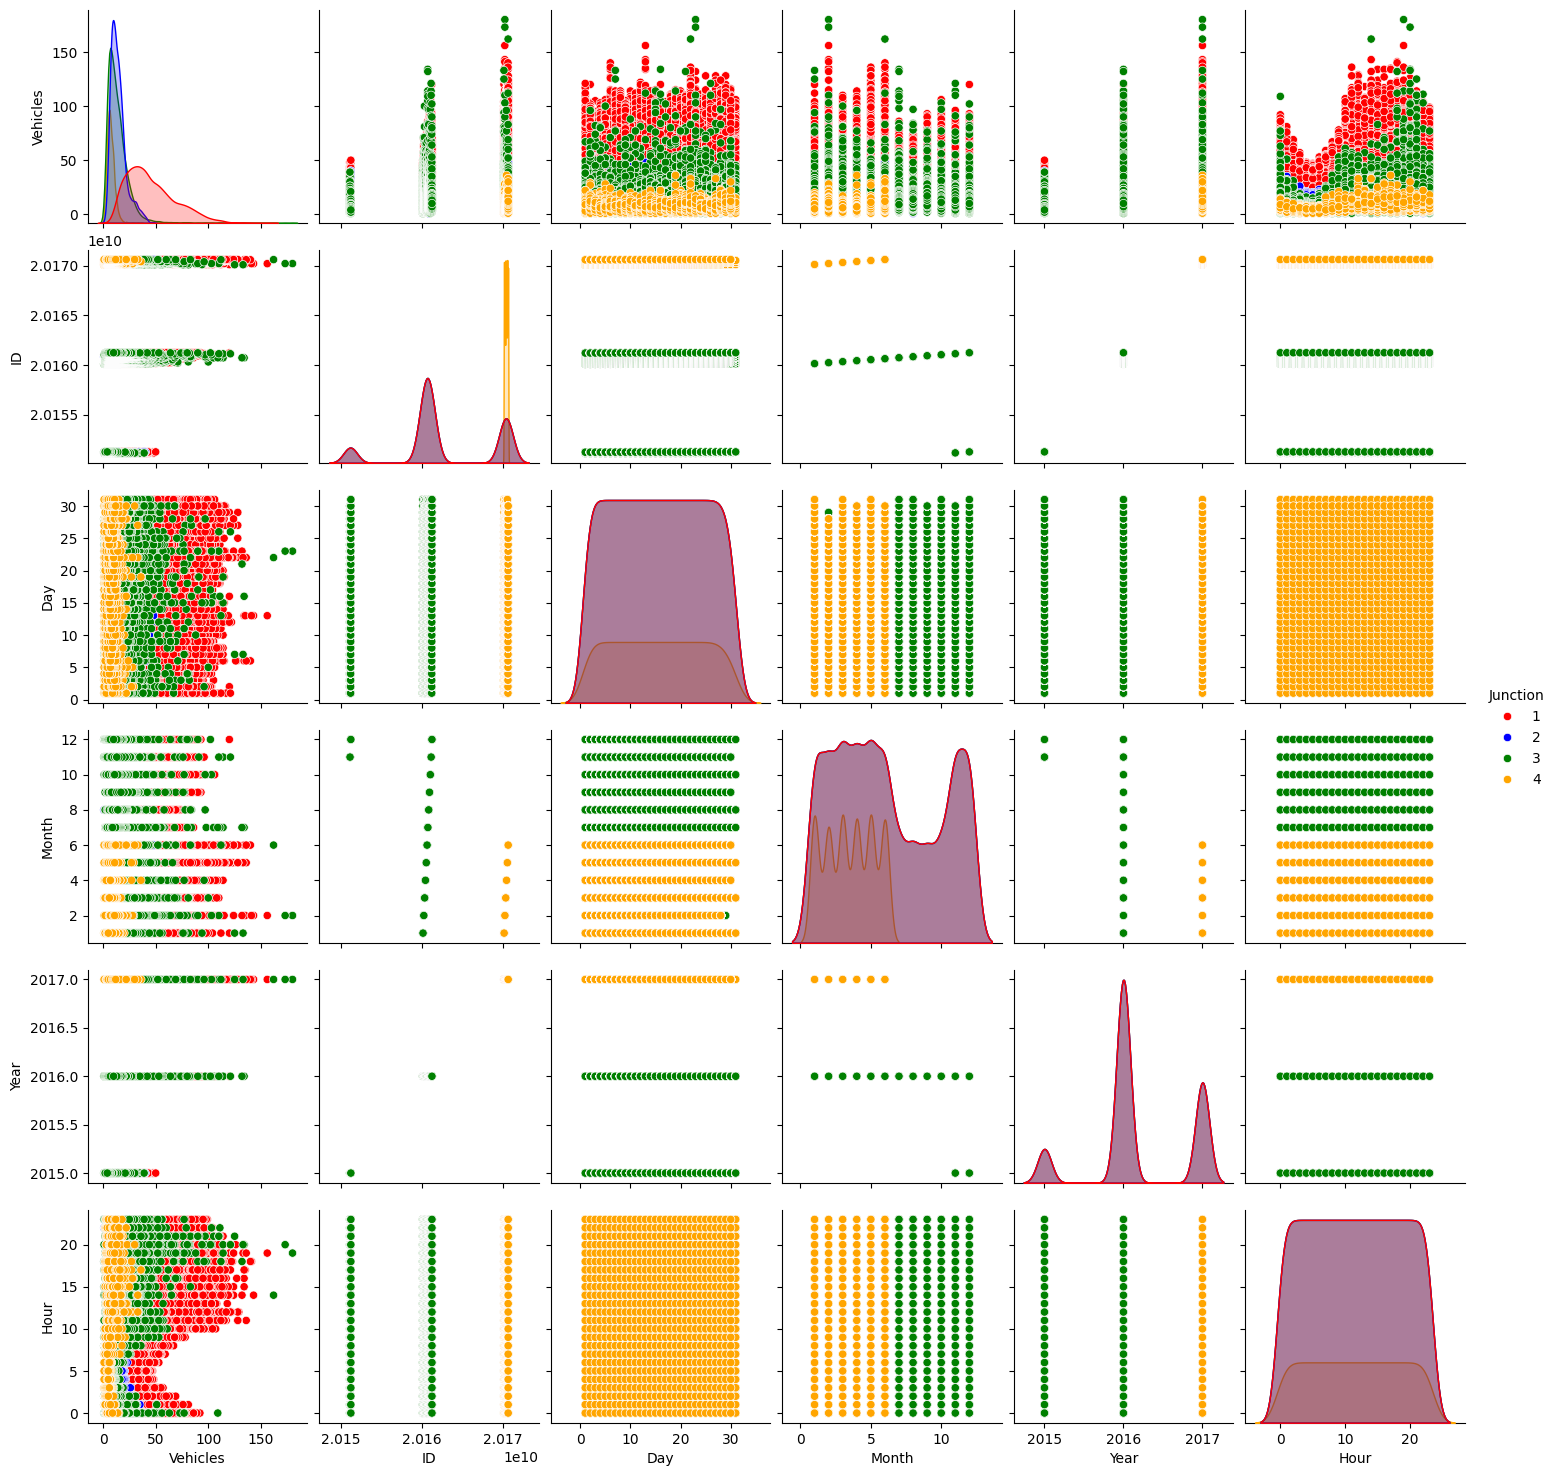

In [13]:
sns.pairplot(data=data, hue= "Junction",palette=custom_palette)


#### Data Transformation And Preprocessing

In [14]:
# Pivoting data from the column, Junction
df_Junc = df.pivot(columns='Junction', index='DateTime')
df_Junc

Vehicles                  
Junction                   1     2     3     4
DateTime                                      
2015-11-01 00:00:00     15.0   6.0   9.0   NaN
2015-11-01 01:00:00     13.0   6.0   7.0   NaN
2015-11-01 02:00:00     10.0   5.0   5.0   NaN
2015-11-01 03:00:00      7.0   6.0   1.0   NaN
2015-11-01 04:00:00      9.0   7.0   2.0   NaN
...                      ...   ...   ...   ...
2017-06-30 19:00:00    105.0  34.0  33.0  11.0
2017-06-30 20:00:00     96.0  35.0  31.0  30.0
2017-06-30 21:00:00     90.0  31.0  28.0  16.0
2017-06-30 22:00:00     84.0  29.0  26.0  22.0
2017-06-30 23:00:00     78.0  27.0  39.0  12.0

[14592 rows x 4 columns]

In [15]:
df_1 = df_Junc[[('Vehicles', 1)]]
df_2 = df_Junc[[('Vehicles', 2)]]
df_3 = df_Junc[[('Vehicles', 3)]]
df_4 = df_Junc[[('Vehicles', 4)]].dropna() # Junction 4 has NaN values since data is limited

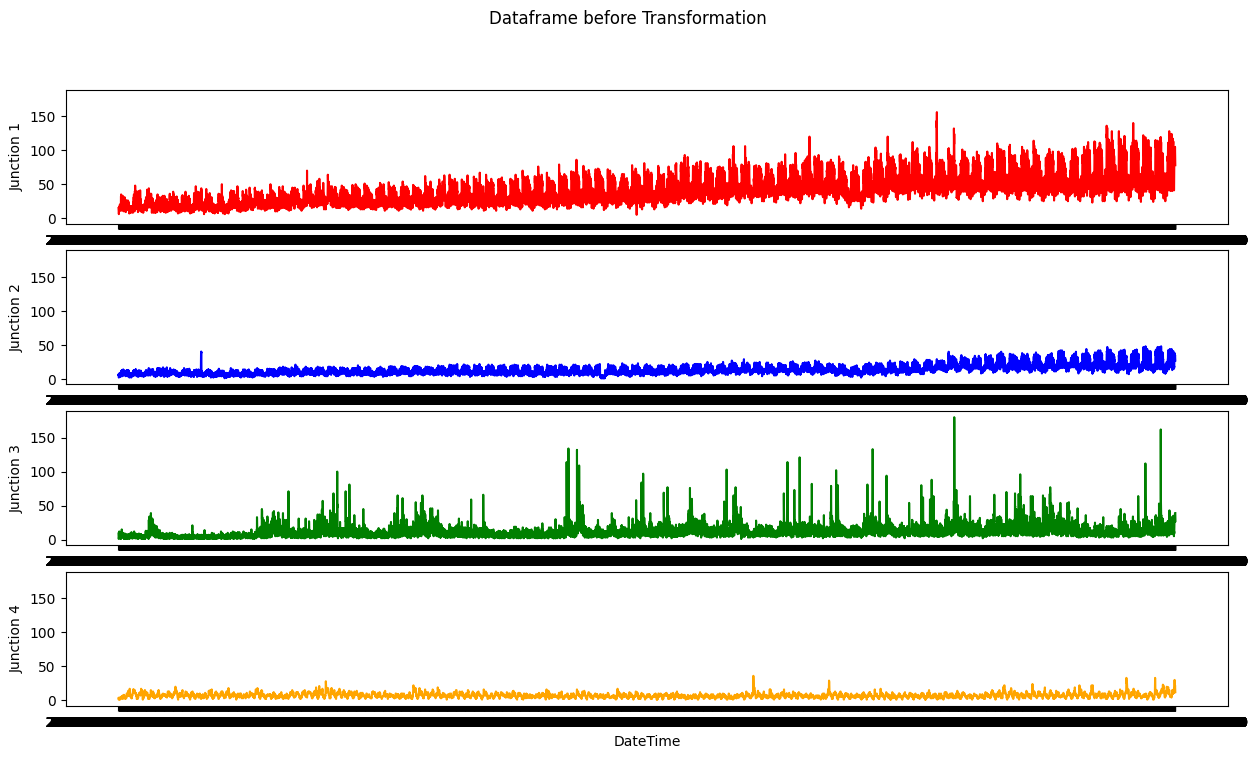

In [16]:
colors = np.array(list(custom_palette.values()))

list_dfs = [df_1, df_2, df_3, df_4]
for i in list_dfs:
    i.columns= i.columns.droplevel(level=1)

# Plotting dataframes for each junction after dropping the junction columns
def Sub_Plots(df_1, df_2,df_3,df_4,title):
    fig, axes = plt.subplots(4, 1, figsize=(15, 8), sharey=True)
    fig.suptitle(title)

    #J1
    pl_1=sns.lineplot(ax=axes[0], data=df_1,color='red')
    axes[0].set(ylabel ="Junction 1")
    #J2
    pl_2=sns.lineplot(ax=axes[1], data=df_2, color=colors[1])
    axes[1].set(ylabel ="Junction 2")
    #J3
    pl_3=sns.lineplot(ax=axes[2], data=df_3, color=colors[2])
    axes[2].set(ylabel ="Junction 3")
    #J4
    pl_4=sns.lineplot(ax=axes[3], data=df_4, color=colors[3])
    axes[3].set(ylabel ="Junction 4")


Sub_Plots(df_1.Vehicles, df_2.Vehicles, df_3.Vehicles, df_4.Vehicles, 'Dataframe before Transformation')

In [17]:
def Normalize(df, col):
  average = df[col].mean()
  std = df[col].std()
  normalize_df = df[col].transform(lambda x: (x - average)/std).to_frame()
  return average, std, normalize_df


def Difference(df,col, interval):
    diff = []
    for i in range(interval, len(df)):
        value = df[col][i] - df[col][i - interval]
        diff.append(value)
    return diff

In [18]:
df1_average, df1_std, df1_normalized  = Normalize(df_1, 'Vehicles')
diff_1 = Difference(df1_normalized, 'Vehicles', (24*7)) # a week's difference
df1_normalized = df1_normalized[24*7:]
df1_normalized.columns = ['Norms']
df1_normalized['Diff'] = diff_1

df2_average, df2_std, df2_normalized  = Normalize(df_2, 'Vehicles')
diff_2 = Difference(df2_normalized, 'Vehicles', 24) # a day's difference
df2_normalized = df2_normalized[24:]
df2_normalized.columns = ['Norms']
df2_normalized['Diff'] = diff_2


df3_average, df3_std, df3_normalized  = Normalize(df_3, 'Vehicles')
diff_3 = Difference(df3_normalized, 'Vehicles', 1) # an hour's difference
df3_normalized = df3_normalized[1:]
df3_normalized.columns = ['Norms']
df3_normalized['Diff'] = diff_3

df4_average, df4_std, df4_normalized  = Normalize(df_4, 'Vehicles')
diff_4 = Difference(df4_normalized, 'Vehicles', 1)  # an hour's difference
df4_normalized = df4_normalized[1:]
df4_normalized.columns = ['Norms']
df4_normalized['Diff'] = diff_4


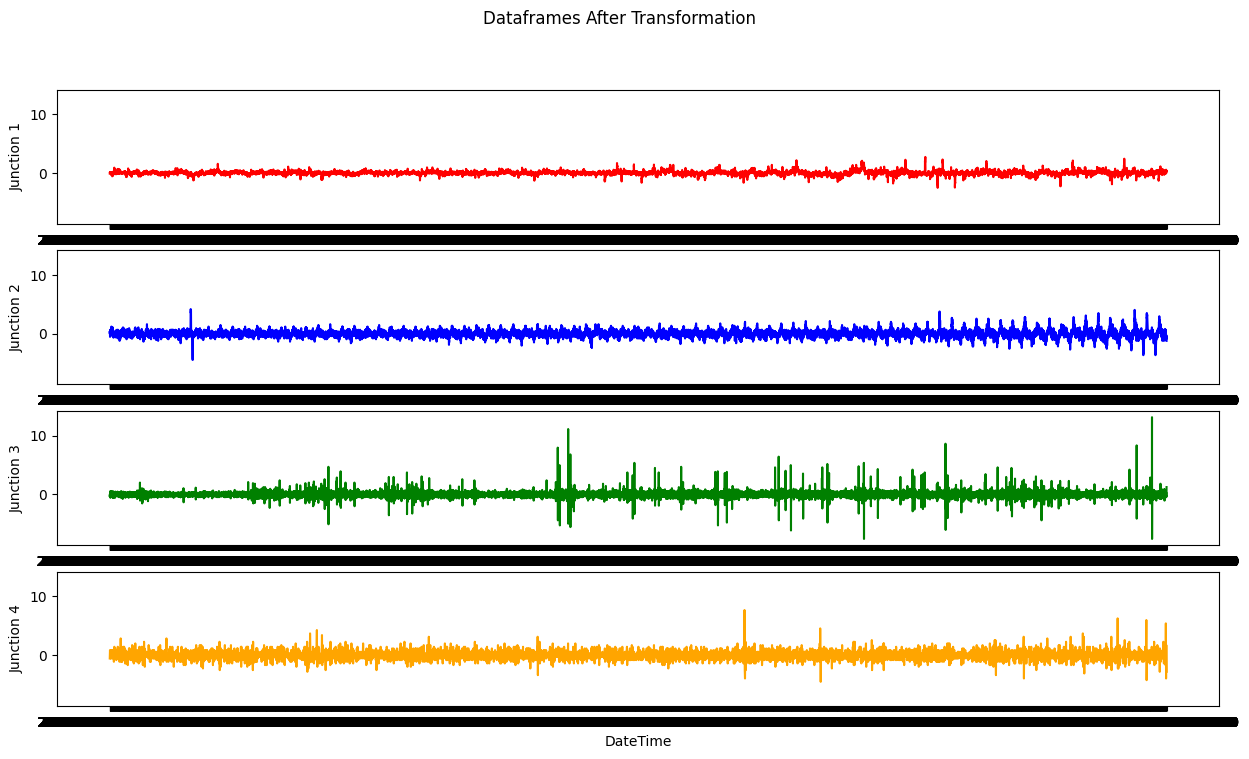

In [19]:
Sub_Plots(df1_normalized.Diff,df2_normalized.Diff,df3_normalized.Diff,df4_normalized.Diff,"Dataframes After Transformation")

In [20]:
def check_stationarity(df):
    check = adfuller(df.dropna())
    print(f"ADF Statistic: {check[0]}")
    print(f"p-value: {check[1]}")

    for key, value in check[4].items():
        print('\t%s: %.3f' % (key, value))

    if check[0] > check[4]["1%"]:
      print("Fail to reject the null hypothesis (H0) - Time series is non-stationary.")
    else:
      print("Reject the null hypothesis (H0) - Time series is stationary.")


df_list = [df1_normalized['Diff'], df2_normalized['Diff'], df3_normalized['Diff'], df4_normalized['Diff']]

print("Checking the transformed series for stationarity:")
for df in df_list:
  print("\n")
  check_stationarity(df)

Checking the transformed series for stationarity:


ADF Statistic: -15.265303390415337
p-value: 4.79853987639816e-28
	1%: -3.431
	5%: -2.862
	10%: -2.567
Reject the null hypothesis (H0) - Time series is stationary.


ADF Statistic: -21.795891026940065
p-value: 0.0
	1%: -3.431
	5%: -2.862
	10%: -2.567
Reject the null hypothesis (H0) - Time series is stationary.


ADF Statistic: -28.001759908832316
p-value: 0.0
	1%: -3.431
	5%: -2.862
	10%: -2.567
Reject the null hypothesis (H0) - Time series is stationary.


ADF Statistic: -17.979092563052276
p-value: 2.778787532595421e-30
	1%: -3.432
	5%: -2.862
	10%: -2.567
Reject the null hypothesis (H0) - Time series is stationary.


**Splitting the data into Train and Test**

In [21]:
df1_Junc = df1_normalized['Diff'].dropna()
df1_Junc = df1_Junc.to_frame()

df2_Junc = df2_normalized['Diff'].dropna()
df2_Junc = df2_Junc.to_frame()

df3_Junc = df3_normalized['Diff'].dropna()
df3_Junc = df3_Junc.to_frame()

df4_Junc = df4_normalized['Diff'].dropna()
df4_Junc = df4_Junc.to_frame()

In [22]:
def split_data(df):
  data_len = len(df)
  train_size = int(0.9*data_len)
  train, test = df[0:train_size], df[train_size:data_len]
  train, test = train.values.reshape(-1, 1), test.values.reshape(-1, 1)

  return train, test

In [23]:
train_j1, test_j1 = split_data(df1_Junc)
train_j2, test_j2 = split_data(df2_Junc)
train_j3, test_j3 = split_data(df3_Junc)
train_j4, test_j4 = split_data(df4_Junc)

In [24]:
# Allocating targets and feature

def target_and_feature(df):
  X = []
  y = []
  steps = 32

  for i in range(steps, len(df)):
    X.append(df[i - steps:i, 0])
    y.append(df[i, 0])
  X, y = np.array(X), np.array(y)
  return X ,y

In [25]:
def FixFeatureShape(train, test):
  train = np.reshape(train, (train.shape[0], train.shape[1], 1))
  test = np.reshape(test, (test.shape[0],test.shape[1],1))
  return train, test


In [26]:
X_trainJ1, y_trainJ1 = target_and_feature(train_j1)
X_testJ1, y_testJ1 = target_and_feature(test_j1)
X_trainJ1, X_testJ1 = FixFeatureShape(X_trainJ1, X_testJ1)

X_trainJ2, y_trainJ2 = target_and_feature(train_j1)
X_testJ2, y_testJ2 = target_and_feature(test_j1)
X_trainJ2, X_testJ2 = FixFeatureShape(X_trainJ2, X_testJ2)

X_trainJ3, y_trainJ3 = target_and_feature(train_j1)
X_testJ3, y_testJ3 = target_and_feature(test_j1)
X_trainJ3, X_testJ3 = FixFeatureShape(X_trainJ3, X_testJ3)

X_trainJ4, y_trainJ4 = target_and_feature(train_j4)
X_testJ4, y_testJ4 = target_and_feature(test_j4)
X_trainJ4, X_testJ4 = FixFeatureShape(X_trainJ4, X_testJ4)

### Model Building

In [27]:
# Custom Layer
class CustomLayer(layers.Layer):
    def __init__(self, units=32):
        super(CustomLayer, self).__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.b = self.add_weight(
            shape=(self.units,),
            initializer="zeros",
            trainable=True,
        )

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b


In [28]:
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9)

# Custom_Model for the prediction
def Custom_model(X_Train, y_Train, X_Test, y_Test):
    early_stopping = callbacks.EarlyStopping(min_delta=0.001,patience=10, restore_best_weights=True)
    model = Sequential()
    model.add(layers.Flatten(input_shape=(X_Train.shape[1], X_Train.shape[2])))  # Flatten layer
    model.add(Dense(150, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(CustomLayer(50))  # Custom layer
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer=SGD(learning_rate=lr_schedule, momentum=0.9), loss='mean_squared_error')
    model.fit(X_Train, y_Train, validation_data=(X_Test, y_Test), epochs=50, batch_size=120, callbacks=[early_stopping])
    pred_Custom = model.predict(X_Test)
    return pred_Custom

#GRU Model for the prediction
def GRU_model(X_Train, y_Train, X_Test, y_Test):
    early_stopping = callbacks.EarlyStopping(min_delta=0.001,patience=10, restore_best_weights=True)
    #callback delta 0.01 may interrupt the learning.

    #The GRU model
    model = Sequential()
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    #model.add(GRU(units=50, return_sequences=True,  input_shape=(X_Train.shape[1],1),activation='tanh'))
    #model.add(Dropout(0.2))
    model.add(GRU(units=50, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))

    #Compiling the model
    model.compile(optimizer=SGD(learning_rate=lr_schedule, momentum=0.9),loss='mean_squared_error')
    model.fit(X_Train,y_Train, validation_data=(X_Test, y_Test), epochs=50, batch_size=120,callbacks=[early_stopping])
    pred_GRU= model.predict(X_Test)
    return pred_GRU

# LSTM Model for the prediction
def LSTM_model(X_Train, y_Train, X_Test, y_Test):
    early_stopping = callbacks.EarlyStopping(min_delta=0.001,patience=10, restore_best_weights=True)

    #The LSTM model
    model = Sequential()
    model.add(LSTM(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(LSTM(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))

    #Compiling the model
    model.compile(optimizer=SGD(learning_rate=lr_schedule, momentum=0.9),loss='mean_squared_error')
    model.fit(X_Train,y_Train, validation_data=(X_Test, y_Test), epochs=50, batch_size=120,callbacks=[early_stopping])
    pred_LSTM = model.predict(X_Test)
    return pred_LSTM

# CNN Model for the prediction
def CNN_model(X_Train, y_Train, X_Test, y_Test):
    early_stopping = callbacks.EarlyStopping(min_delta=0.001,patience=10, restore_best_weights=True)

    #The CNN model
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_Train.shape[1],1)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(units=1))

    #Compiling the model
    model.compile(optimizer=SGD(learning_rate=lr_schedule, momentum=0.9),loss='mean_squared_error')
    model.fit(X_Train,y_Train, validation_data=(X_Test, y_Test), epochs=50, batch_size=120,callbacks=[early_stopping])
    pred_CNN = model.predict(X_Test)
    return pred_CNN

# # MLP Model for the prediction
# def MLP_model(X_Train, y_Train, X_Test, y_Test):
#     X_Train = np.squeeze(X_Train)  # This line removes the unnecessary dimension
#     X_Test = np.squeeze(X_Test)    # Do the same for the test data
#     early_stopping = callbacks.EarlyStopping(min_delta=0.001,patience=10, restore_best_weights=True)
#     model = Sequential()
#     model.add(Dense(150, activation='relu', input_dim=X_Train.shape[1]))
#     model.add(Dropout(0.2))
#     model.add(Dense(150, activation='relu'))
#     model.add(Dropout(0.2))
#     model.add(Dense(50, activation='relu'))
#     model.add(Dropout(0.2))
#     model.add(Dense(50, activation='relu'))
#     model.add(Dropout(0.2))
#     model.add(Dense(50, activation='relu'))
#     model.add(Dropout(0.2))
#     model.add(Dense(units=1))
#     model.compile(optimizer=SGD(learning_rate=lr_schedule, momentum=0.9),loss='mean_squared_error')
#     model.fit(X_Train, y_Train, validation_data=(X_testJ1, y_testJ1), epochs=50, batch_size=120, callbacks=[early_stopping])
#     pred_MLP = model.predict(X_Test)
#     return pred_MLP

#To calculate the root mean squred error in predictions
def RMSE_Value(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    return rmse

#To plot the comparitive plot of targets and predictions
def PredictionsPlot(test,predicted,m):
    plt.figure(figsize=(12,5),facecolor="#99ccff")
    plt.plot(test, color=colors[m],label="True Value",alpha=0.5 )
    plt.plot(predicted, color="#627D78",label="Predicted Values")
    plt.title("Traffic Prediction Vs True values")
    plt.xlabel("DateTime")
    plt.ylabel("Number of Vehicles")
    plt.legend()
    plt.show()



### Fitting the Model

In [29]:
#Predictions For First Junction
print("\033[1;31;2m########------Custom Model------########\033[0m")
PredJ1_Custom = Custom_model(X_trainJ1,y_trainJ1,X_testJ1, y_testJ1)
print("-" * 70)

print("\033[1;31;2m########------GRU Model------########\033[0m")
PredJ1_GRU = GRU_model(X_trainJ1,y_trainJ1,X_testJ1, y_testJ1)
print("-" * 70)

print("\033[1;34;2m########------LSTM Model------########\033[0m")
PredJ1_LSTM = LSTM_model(X_trainJ1,y_trainJ1,X_testJ1, y_testJ1)
print("-" * 70)

print("\033[1;32;2m########------CNN Model------########\033[0m")
PredJ1_CNN = CNN_model(X_trainJ1,y_trainJ1,X_testJ1, y_testJ1)
print("-" * 70)

# print("\033[1;33;2m########------MLP Model------########\033[0m")
# PredJ1_MLP = MLP_model(X_trainJ1,y_trainJ1,X_testJ1, y_testJ1)
# print("-" * 70)


########------Custom Model------########
Epoch 1/50
108/108 [==============================] - 2s 6ms/step - loss: 0.0708 - val_loss: 0.0695
Epoch 2/50
108/108 [==============================] - 0s 3ms/step - loss: 0.0568 - val_loss: 0.0629
Epoch 3/50
108/108 [==============================] - 0s 4ms/step - loss: 0.0542 - val_loss: 0.0603
Epoch 4/50
108/108 [==============================] - 0s 4ms/step - loss: 0.0527 - val_loss: 0.0601
Epoch 5/50
108/108 [==============================] - 0s 4ms/step - loss: 0.0512 - val_loss: 0.0590
Epoch 6/50
108/108 [==============================] - 0s 4ms/step - loss: 0.0500 - val_loss: 0.0585
Epoch 7/50
108/108 [==============================] - 0s 4ms/step - loss: 0.0489 - val_loss: 0.0590
Epoch 8/50
108/108 [==============================] - 0s 4ms/step - loss: 0.0489 - val_loss: 0.0577
Epoch 9/50
108/108 [==============================] - 0s 4ms/step - loss: 0.0487 - val_loss: 0.0578
Epoch 10/50
108/108 [==============================] - 0s 4

########------Custom Model------########
The root mean squared error is 0.24018621283753827.


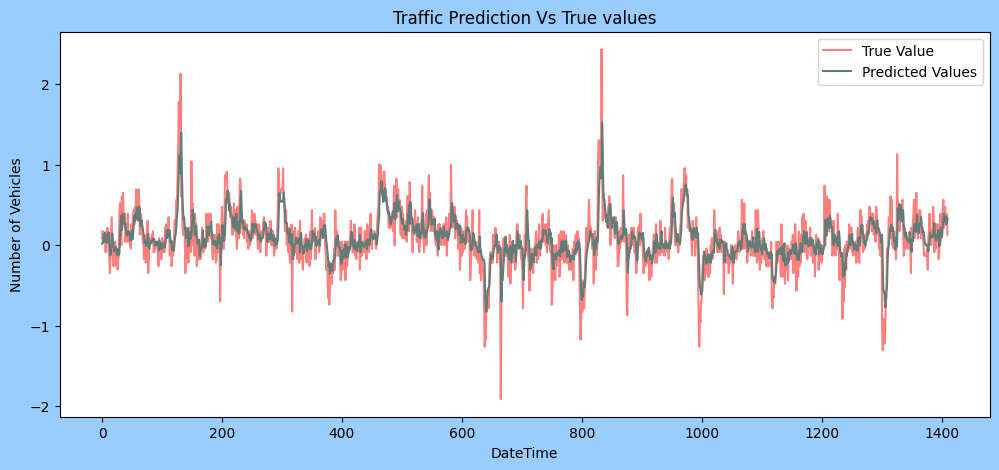

########------GRU Model------########
The root mean squared error is 0.248366265875257.


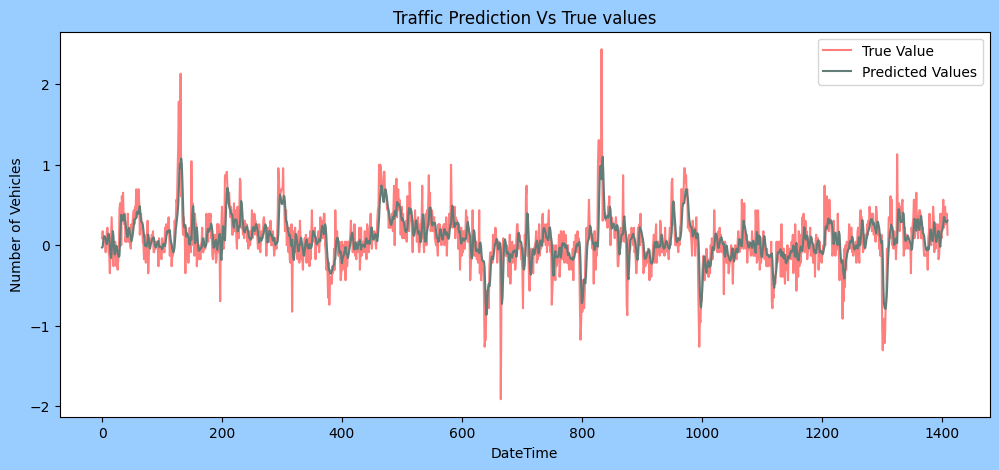


########------LSTM Model------########
The root mean squared error is 0.27131144748568276.


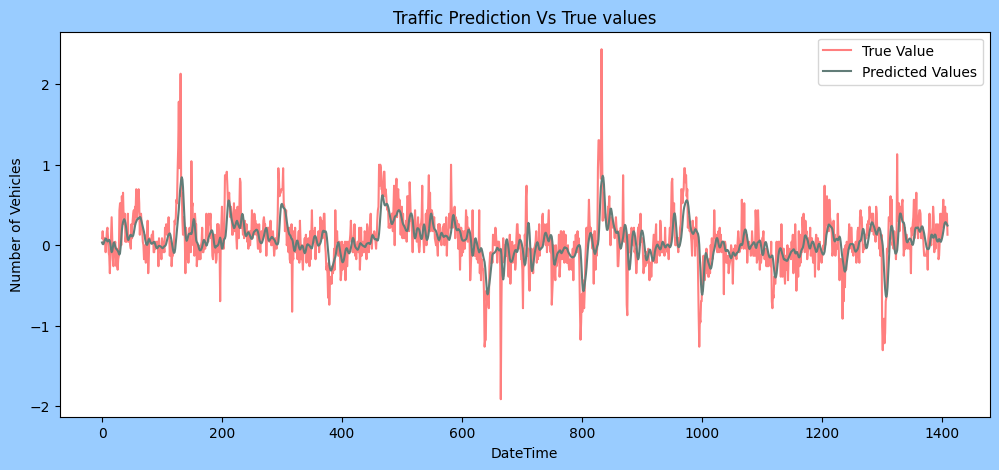


########------CNN Model------########
The root mean squared error is 0.24520212876435174.


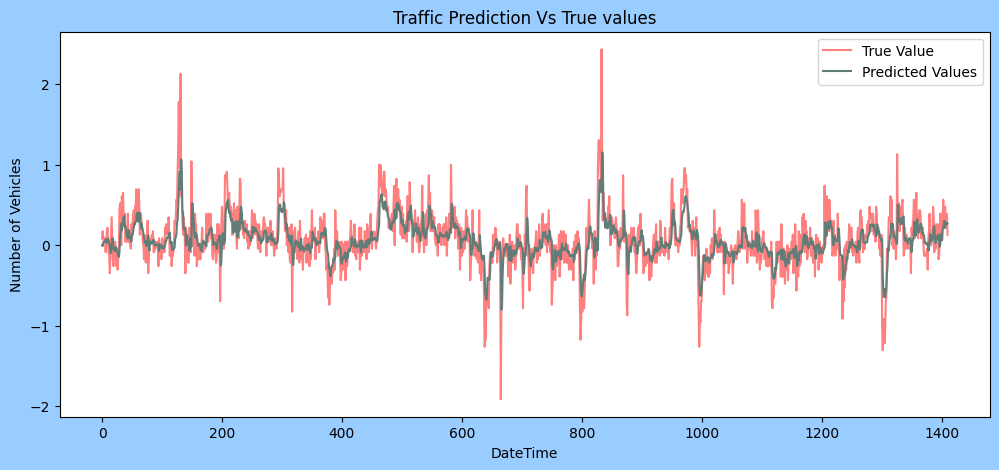


Best Model: Custom - RMSE: 0.24018621283753827



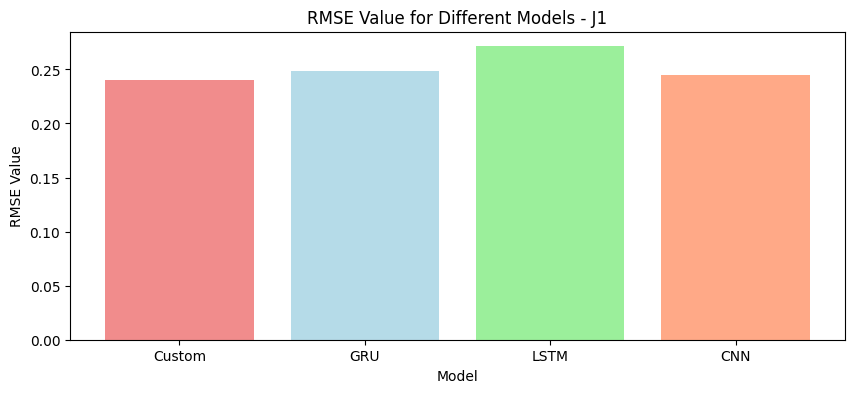

In [30]:
# Results for J1 - Custom Model
print("\033[1;31;2m########------Custom Model------########\033[0m")
RMSE_J1_Custom = RMSE_Value(y_testJ1, PredJ1_Custom)
PredictionsPlot(y_testJ1, PredJ1_Custom, 0)

# Results for J1 - GRU Model
print("\033[1;31;2m########------GRU Model------########\033[0m")
RMSE_J1_GRU = RMSE_Value(y_testJ1, PredJ1_GRU)
PredictionsPlot(y_testJ1, PredJ1_GRU, 0)

# Results for J1 - LSTM Model
print("\n\033[1;34;2m########------LSTM Model------########\033[0m")
RMSE_J1_LSTM = RMSE_Value(y_testJ1, PredJ1_LSTM)
PredictionsPlot(y_testJ1, PredJ1_LSTM, 0)

# Results for J1 - CNN Model
print("\n\033[1;32;2m########------CNN Model------########\033[0m")
RMSE_J1_CNN = RMSE_Value(y_testJ1, PredJ1_CNN)
PredictionsPlot(y_testJ1, PredJ1_CNN, 0)

# # Results for J1 - MLP Model
# print("\n\033[1;33;2m########------MLP Model------########\033[0m")
# RMSE_J1_MLP = RMSE_Value(y_testJ1, PredJ1_MLP)
# PredictionsPlot(y_testJ1, PredJ1_MLP, 0)

# Create a list of model names and their corresponding RMSE values
model_names = ["Custom", "GRU", "LSTM", "CNN"] # "MLP"]
rmse_values = [RMSE_J1_Custom, RMSE_J1_GRU, RMSE_J1_LSTM, RMSE_J1_CNN ] #, RMSE_J1_MLP]

model_rmse = list(zip(model_names, rmse_values))
Results_df = pd.DataFrame(model_rmse, columns=["MODEL", "RMSE"])
styled_df = Results_df.style.background_gradient(cmap="cool")

# Find the best model with the minimum RMSE value
best_model_index = rmse_values.index(min(rmse_values))
best_model_name_1 = model_names[best_model_index]
best_model_rmse_1 = rmse_values[best_model_index]

# Print the best model name and its RMSE value
print("\n\033[1;31;4mBest Model: {} - RMSE: {}\n".format(best_model_name_1, best_model_rmse_1))

# Plot the bar graph for model names and RMSE values with transparency and lighter colors
colors = ['lightcoral', 'lightblue', 'lightgreen', 'lightsalmon' ] #'lightyellow']
alpha = 0.9
fig, ax = plt.subplots(figsize=(10, 4))  # Set the figure size (width, height)
ax.bar(model_names, rmse_values, color=colors, alpha=alpha)
ax.set_xlabel('Model')
ax.set_ylabel('RMSE Value')
ax.set_title('RMSE Value for Different Models - J1')
plt.show()

display(styled_df)


In [31]:
# Predictions For Second Junction
print("\033[1;31;2m########------Custom Model------########\033[0m")
PredJ2_Custom = Custom_model(X_trainJ2, y_trainJ2, X_testJ2, y_testJ2)
print("-" * 70)
print("\033[1;31;2m########------GRU Model------########\033[0m")
PredJ2_GRU = GRU_model(X_trainJ2, y_trainJ2, X_testJ2, y_testJ2)
print("-" * 70)
print("\033[1;34;2m########------LSTM Model------########\033[0m")
PredJ2_LSTM = LSTM_model(X_trainJ2, y_trainJ2, X_testJ2, y_testJ2)
print("-" * 70)
print("\033[1;32;2m########------CNN Model------########\033[0m")
PredJ2_CNN = CNN_model(X_trainJ2, y_trainJ2, X_testJ2, y_testJ2)
print("-" * 70)
# print("\033[1;33;2m########------MLP Model------########\033[0m")
# PredJ2_MLP = MLP_model(X_trainJ2, y_trainJ2, X_testJ2, y_testJ2)
# print("-" * 70)


########------Custom Model------########
Epoch 1/50
108/108 [==============================] - 2s 8ms/step - loss: 0.0710 - val_loss: 0.0753
Epoch 2/50
108/108 [==============================] - 0s 4ms/step - loss: 0.0577 - val_loss: 0.0671
Epoch 3/50
108/108 [==============================] - 0s 4ms/step - loss: 0.0537 - val_loss: 0.0637
Epoch 4/50
108/108 [==============================] - 0s 4ms/step - loss: 0.0520 - val_loss: 0.0614
Epoch 5/50
108/108 [==============================] - 0s 4ms/step - loss: 0.0512 - val_loss: 0.0608
Epoch 6/50
108/108 [==============================] - 0s 4ms/step - loss: 0.0506 - val_loss: 0.0601
Epoch 7/50
108/108 [==============================] - 0s 4ms/step - loss: 0.0494 - val_loss: 0.0596
Epoch 8/50
108/108 [==============================] - 0s 4ms/step - loss: 0.0482 - val_loss: 0.0591
Epoch 9/50
108/108 [==============================] - 0s 4ms/step - loss: 0.0481 - val_loss: 0.0590
Epoch 10/50
108/108 [==============================] - 0s 4

########------Custom Model------########
The root mean squared error is 0.24091801768781174.


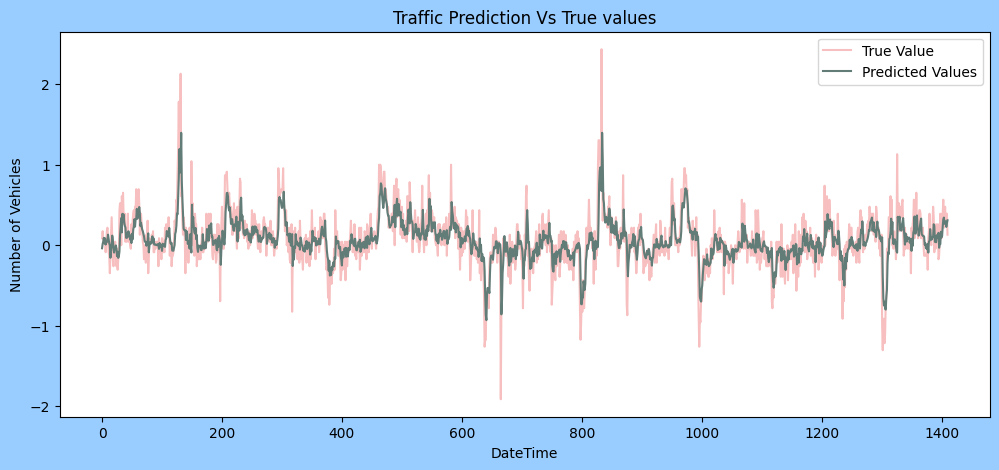

########------GRU Model------########
The root mean squared error is 0.249060937818382.


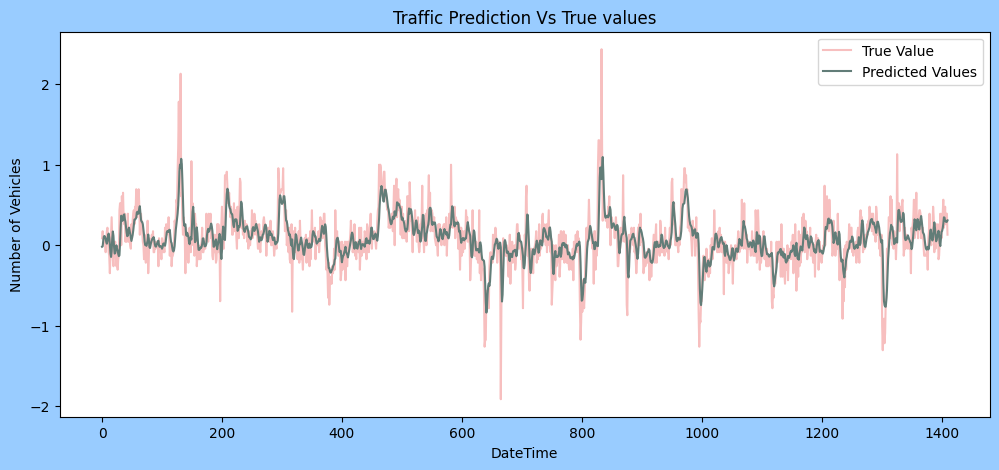


########------LSTM Model------########
The root mean squared error is 0.2714047303785586.


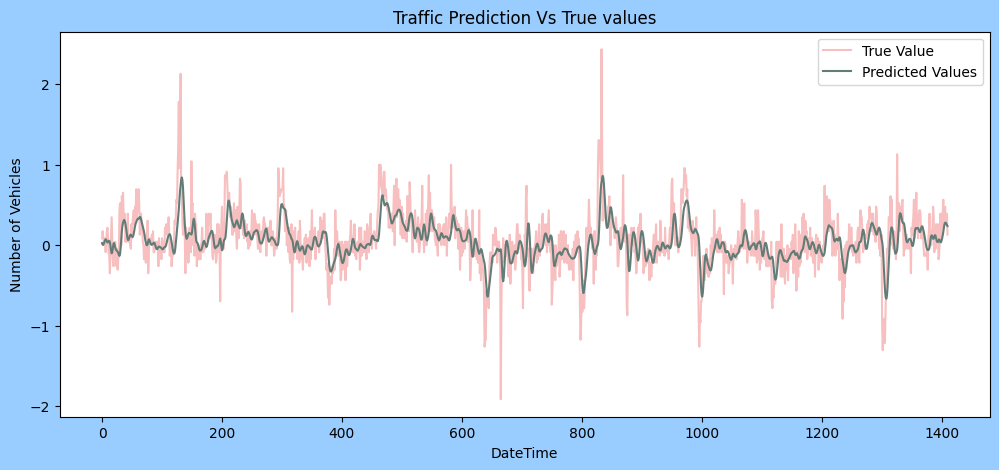


########------CNN Model------########
The root mean squared error is 0.2477245224761402.


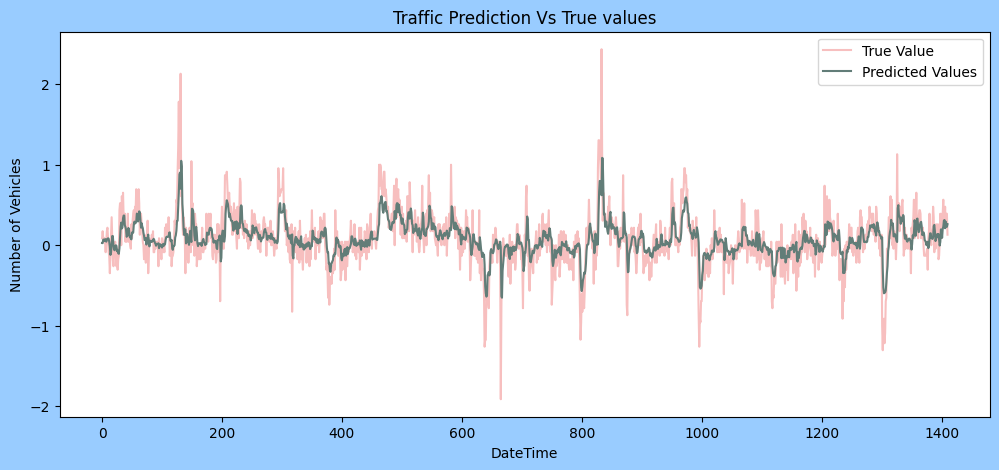


Best Model: Custom - RMSE: 0.24091801768781174



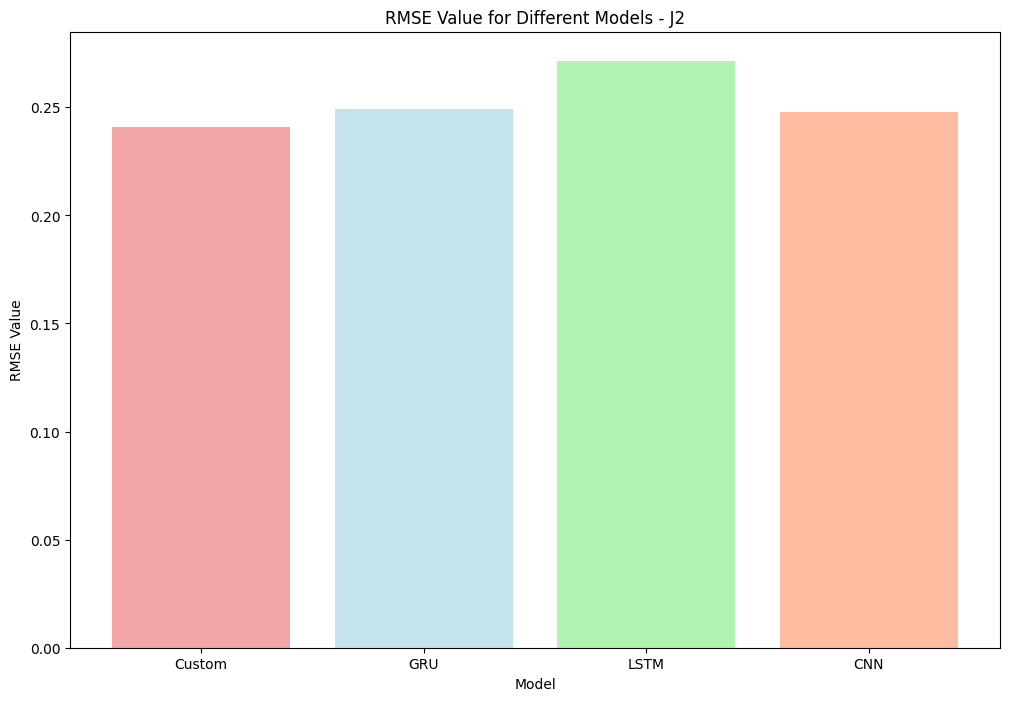

In [32]:
# Results for J2 - Custom Model
print("\033[1;31;2m########------Custom Model------########\033[0m")
RMSE_J2_Custom = RMSE_Value(y_testJ2, PredJ2_Custom)
PredictionsPlot(y_testJ2, PredJ2_Custom, 0)

# Results for J2 - GRU Model
print("\033[1;31;2m########------GRU Model------########\033[0m")
RMSE_J2_GRU = RMSE_Value(y_testJ2, PredJ2_GRU)
PredictionsPlot(y_testJ2, PredJ2_GRU, 0)

# Results for J2 - LSTM Model
print("\n\033[1;34;2m########------LSTM Model------########\033[0m")
RMSE_J2_LSTM = RMSE_Value(y_testJ2, PredJ2_LSTM)
PredictionsPlot(y_testJ2, PredJ2_LSTM, 0)

# Results for J2 - CNN Model
print("\n\033[1;32;2m########------CNN Model------########\033[0m")
RMSE_J2_CNN = RMSE_Value(y_testJ2, PredJ2_CNN)
PredictionsPlot(y_testJ2, PredJ2_CNN, 0)


# Create a list of model names and their corresponding RMSE values
model_names = ["Custom", "GRU", "LSTM", "CNN"] #, "MLP"]
rmse_values = [RMSE_J2_Custom, RMSE_J2_GRU, RMSE_J2_LSTM, RMSE_J2_CNN ] #, RMSE_J2_MLP]

model_rmse = list(zip(model_names, rmse_values))
Results_df = pd.DataFrame(model_rmse, columns=["MODEL", "RMSE"])
styled_df = Results_df.style.background_gradient(cmap="cool")

# Find the best model with the minimum RMSE value
best_model_index = rmse_values.index(min(rmse_values))
best_model_name_2 = model_names[best_model_index]
best_model_rmse_2 = rmse_values[best_model_index]

# Print the best model name and its RMSE value
print("\n\033[1;31;4mBest Model: {} - RMSE: {}\n".format(best_model_name_2, best_model_rmse_2))

# Plot the bar graph for model names and RMSE values with transparency and lighter colors
colors = ['lightcoral', 'lightblue', 'lightgreen', 'lightsalmon'] #, 'lightyellow']
alpha = 0.7
fig, ax = plt.subplots(figsize=(12, 8))  # Set the figure size (width, height)
ax.bar(model_names, rmse_values, color=colors, alpha=alpha)
ax.set_xlabel('Model')
ax.set_ylabel('RMSE Value')
ax.set_title('RMSE Value for Different Models - J2')
plt.show()

display(styled_df)


In [33]:
# Predictions For Third Junction
print("\033[1;31;2m########------Custom Model------########\033[0m")
PredJ3_Custom = Custom_model(X_trainJ3, y_trainJ3, X_testJ3, y_testJ3)
print("-" * 70)
print("\033[1;31;2m########------GRU Model------########\033[0m")
PredJ3_GRU = GRU_model(X_trainJ3, y_trainJ3, X_testJ3, y_testJ3)
print("-" * 70)
print("\033[1;34;2m########------LSTM Model------########\033[0m")
PredJ3_LSTM = LSTM_model(X_trainJ3, y_trainJ3, X_testJ3, y_testJ3)
print("-" * 70)
print("\033[1;32;2m########------CNN Model------########\033[0m")
PredJ3_CNN = CNN_model(X_trainJ3, y_trainJ3, X_testJ3, y_testJ3)
print("-" * 70)

# print("\033[1;33;2m########------MLP Model------########\033[0m")
# PredJ3_MLP = MLP_model(X_trainJ3, y_trainJ3, X_testJ3, y_testJ3)
# print("-" * 70)


########------Custom Model------########
Epoch 1/50
108/108 [==============================] - 1s 6ms/step - loss: 0.0703 - val_loss: 0.0731
Epoch 2/50
108/108 [==============================] - 0s 4ms/step - loss: 0.0574 - val_loss: 0.0661
Epoch 3/50
108/108 [==============================] - 0s 4ms/step - loss: 0.0545 - val_loss: 0.0639
Epoch 4/50
108/108 [==============================] - 0s 4ms/step - loss: 0.0519 - val_loss: 0.0626
Epoch 5/50
108/108 [==============================] - 0s 4ms/step - loss: 0.0513 - val_loss: 0.0616
Epoch 6/50
108/108 [==============================] - 0s 4ms/step - loss: 0.0502 - val_loss: 0.0613
Epoch 7/50
108/108 [==============================] - 0s 4ms/step - loss: 0.0482 - val_loss: 0.0601
Epoch 8/50
108/108 [==============================] - 0s 4ms/step - loss: 0.0494 - val_loss: 0.0598
Epoch 9/50
108/108 [==============================] - 0s 4ms/step - loss: 0.0482 - val_loss: 0.0599
Epoch 10/50
108/108 [==============================] - 0s 4

########------Custom Model------########
The root mean squared error is 0.24280703214701516.


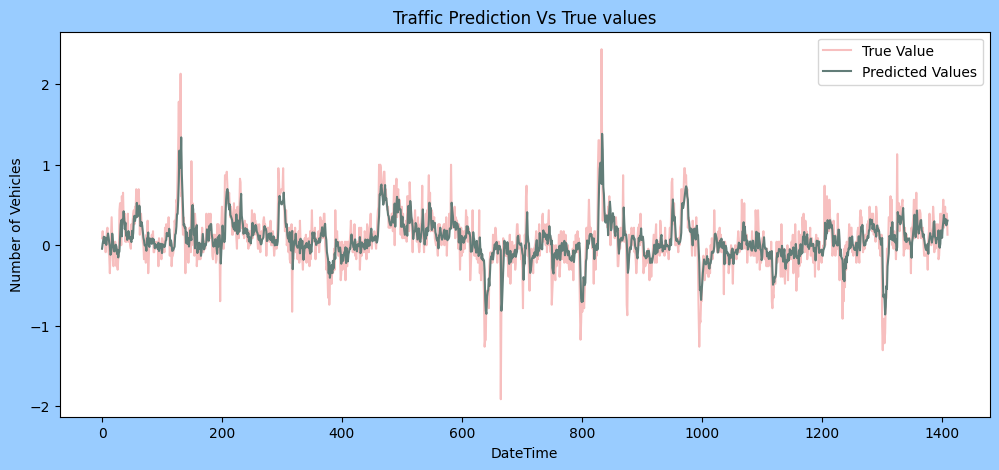

########------GRU Model------########
The root mean squared error is 0.24750363745546036.


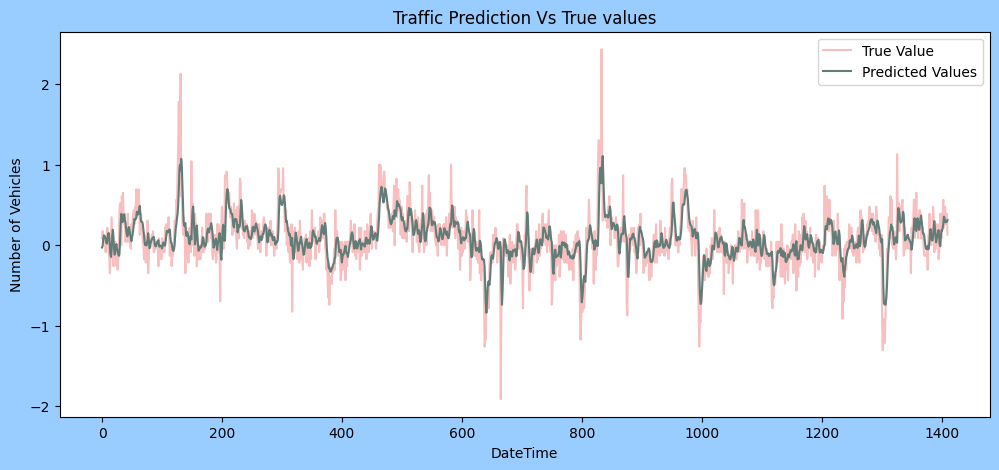


########------LSTM Model------########
The root mean squared error is 0.2729550664994871.


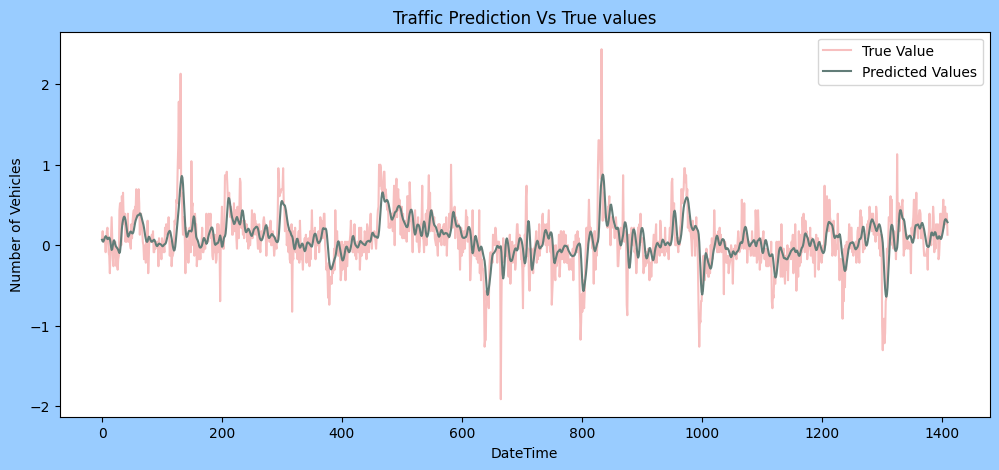


########------CNN Model------########
The root mean squared error is 0.24692616511866672.


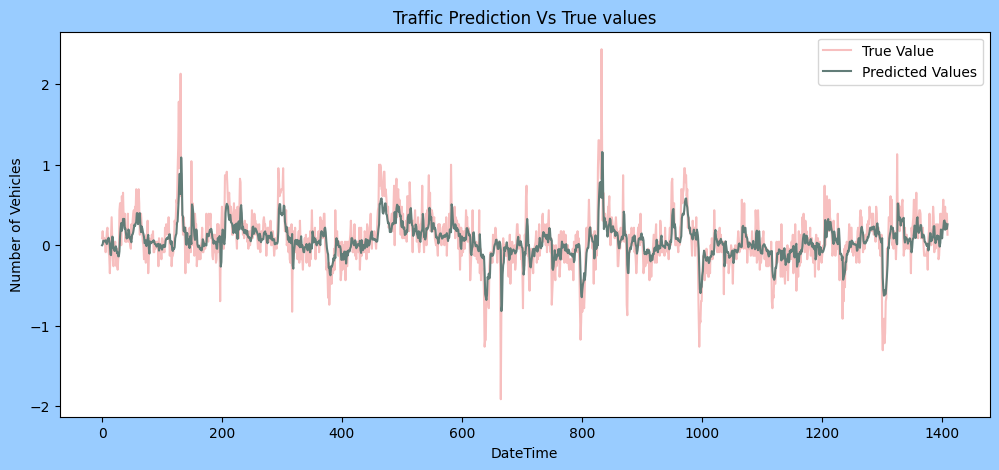


Best Model: Custom - RMSE: 0.24280703214701516



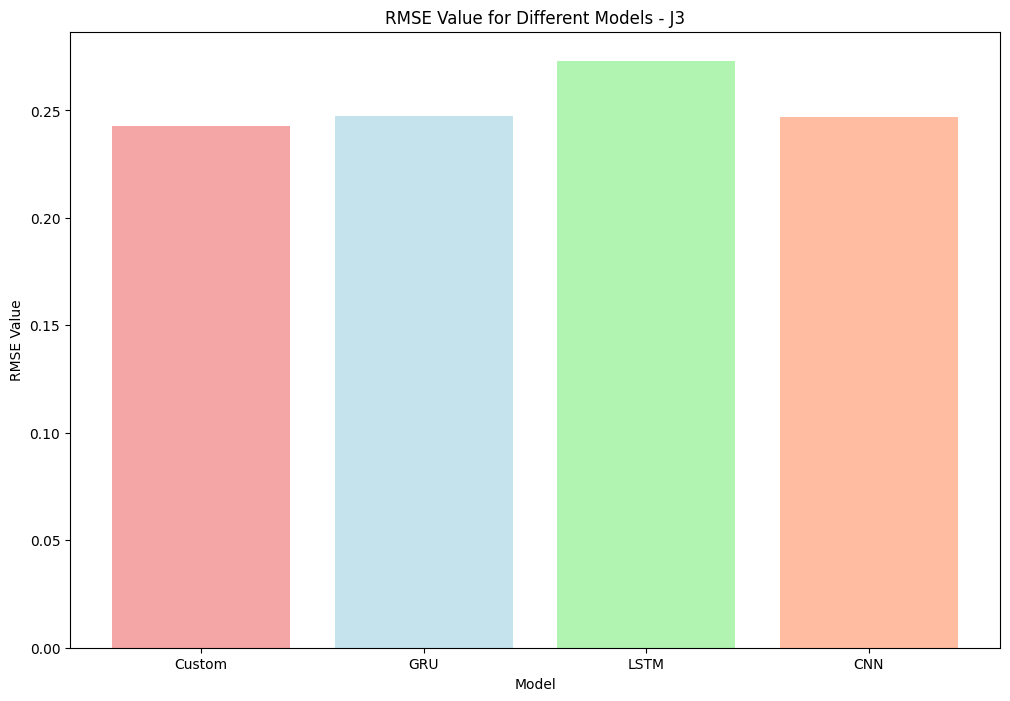

In [34]:
# Results for J3 - Custom Model
print("\033[1;31;2m########------Custom Model------########\033[0m")
RMSE_J3_Custom = RMSE_Value(y_testJ3, PredJ3_Custom)
PredictionsPlot(y_testJ3, PredJ3_Custom, 0)

# Results for J3 - GRU Model
print("\033[1;31;2m########------GRU Model------########\033[0m")
RMSE_J3_GRU = RMSE_Value(y_testJ3, PredJ3_GRU)
PredictionsPlot(y_testJ3, PredJ3_GRU, 0)

# Results for J3 - LSTM Model
print("\n\033[1;34;2m########------LSTM Model------########\033[0m")
RMSE_J3_LSTM = RMSE_Value(y_testJ3, PredJ3_LSTM)
PredictionsPlot(y_testJ3, PredJ3_LSTM, 0)

# Results for J3 - CNN Model
print("\n\033[1;32;2m########------CNN Model------########\033[0m")
RMSE_J3_CNN = RMSE_Value(y_testJ3, PredJ3_CNN)
PredictionsPlot(y_testJ3, PredJ3_CNN, 0)

# # Results for J3 - MLP Model
# print("\n\033[1;33;2m########------MLP Model------########\033[0m")
# RMSE_J3_MLP = RMSE_Value(y_testJ3, PredJ3_MLP)
# PredictionsPlot(y_testJ3, PredJ3_MLP, 0)

# Create a list of model names and their corresponding RMSE values
model_names = ["Custom", "GRU", "LSTM", "CNN"] #, "MLP"]
rmse_values = [RMSE_J3_Custom, RMSE_J3_GRU, RMSE_J3_LSTM, RMSE_J3_CNN] #, RMSE_J3_MLP]

model_rmse = list(zip(model_names, rmse_values))
Results_df = pd.DataFrame(model_rmse, columns=["MODEL", "RMSE"])
styled_df = Results_df.style.background_gradient(cmap="cool")

# Find the best model with the minimum RMSE value
best_model_index = rmse_values.index(min(rmse_values))
best_model_name_3 = model_names[best_model_index]
best_model_rmse_3 = rmse_values[best_model_index]

# Print the best model name and its RMSE value
print("\n\033[1;31;4mBest Model: {} - RMSE: {}\n".format(best_model_name_3, best_model_rmse_3))

# Plot the bar graph for model names and RMSE values with transparency and lighter colors
colors = ['lightcoral', 'lightblue', 'lightgreen', 'lightsalmon'] # , 'lightyellow']
alpha = 0.7
fig, ax = plt.subplots(figsize=(12, 8))  # Set the figure size (width, height)
ax.bar(model_names, rmse_values, color=colors, alpha=alpha)
ax.set_xlabel('Model')
ax.set_ylabel('RMSE Value')
ax.set_title('RMSE Value for Different Models - J3')
plt.show()

display(styled_df)

In [35]:
# Predictions For Fourth Junction
print("\033[1;31;2m########------Custom Model------########\033[0m")
PredJ4_Custom = Custom_model(X_trainJ4, y_trainJ4, X_testJ4, y_testJ4)
print("-" * 70)
print("\033[1;31;2m########------GRU Model------########\033[0m")
PredJ4_GRU = GRU_model(X_trainJ4, y_trainJ4, X_testJ4, y_testJ4)
print("-" * 70)
print("\033[1;34;2m########------LSTM Model------########\033[0m")
PredJ4_LSTM = LSTM_model(X_trainJ4, y_trainJ4, X_testJ4, y_testJ4)
print("-" * 70)
print("\033[1;32;2m########------CNN Model------########\033[0m")
PredJ4_CNN = CNN_model(X_trainJ4, y_trainJ4, X_testJ4, y_testJ4)
print("-" * 70)


# print("\033[1;33;2m########------MLP Model------########\033[0m")
# PredJ4_MLP = MLP_model(X_trainJ4, y_trainJ4, X_testJ4, y_testJ4)
# print("-" * 70)


########------Custom Model------########
Epoch 1/50
33/33 [==============================] - 1s 10ms/step - loss: 0.6714 - val_loss: 1.1293
Epoch 2/50
33/33 [==============================] - 0s 6ms/step - loss: 0.6290 - val_loss: 1.0746
Epoch 3/50
33/33 [==============================] - 0s 6ms/step - loss: 0.5886 - val_loss: 1.0502
Epoch 4/50
33/33 [==============================] - 0s 6ms/step - loss: 0.5571 - val_loss: 1.0372
Epoch 5/50
33/33 [==============================] - 0s 5ms/step - loss: 0.5496 - val_loss: 1.0311
Epoch 6/50
33/33 [==============================] - 0s 5ms/step - loss: 0.5255 - val_loss: 1.0192
Epoch 7/50
33/33 [==============================] - 0s 6ms/step - loss: 0.5255 - val_loss: 1.0010
Epoch 8/50
33/33 [==============================] - 0s 5ms/step - loss: 0.5133 - val_loss: 0.9996
Epoch 9/50
33/33 [==============================] - 0s 5ms/step - loss: 0.5051 - val_loss: 1.0044
Epoch 10/50
33/33 [==============================] - 0s 5ms/step - loss: 0.4

########------Custom Model------########
The root mean squared error is 0.9942208455571908.


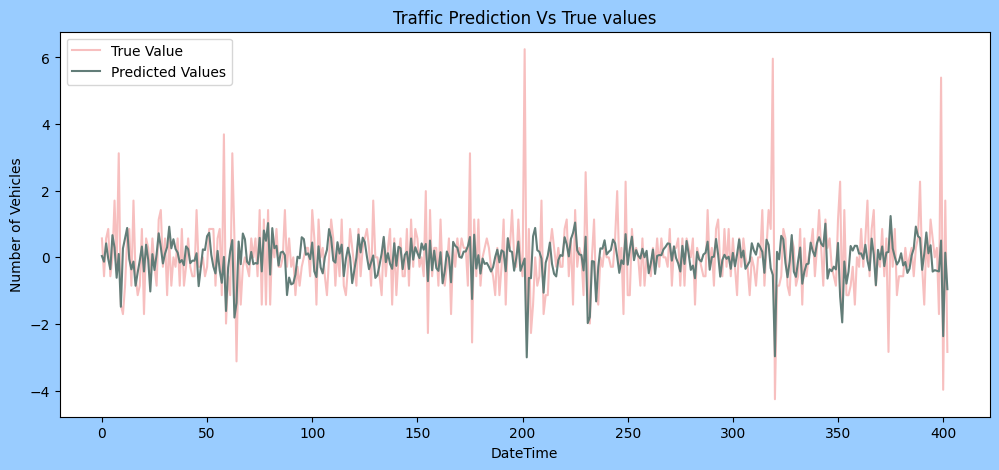

########------GRU Model------########
The root mean squared error is 0.9886384543937081.


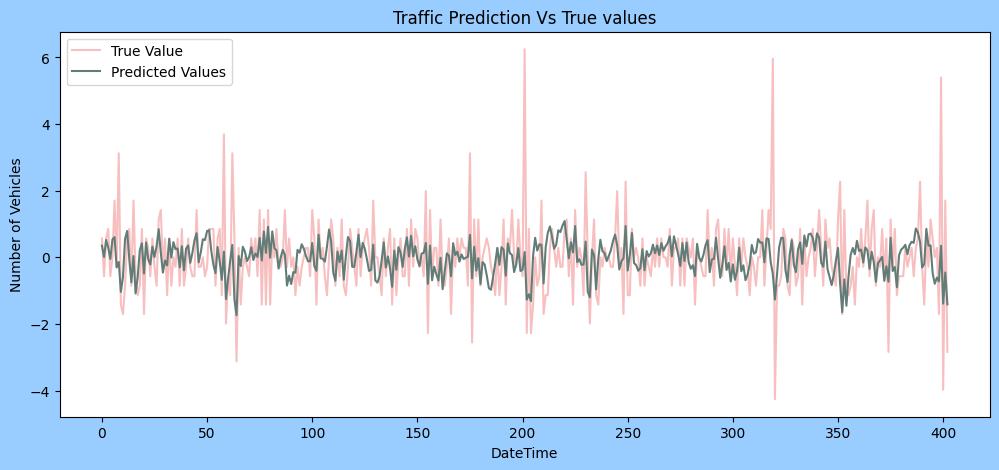


########------LSTM Model------########
The root mean squared error is 1.0966129050113547.


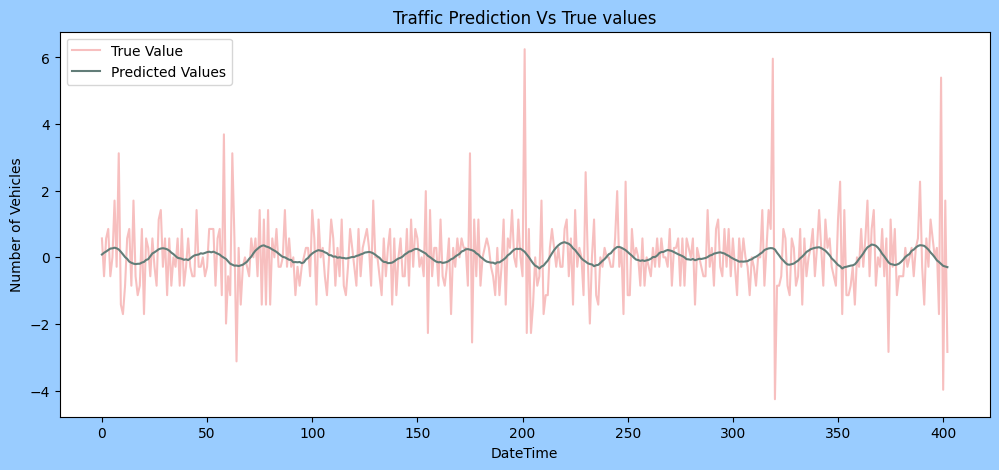


########------CNN Model------########
The root mean squared error is 0.9963183843319336.


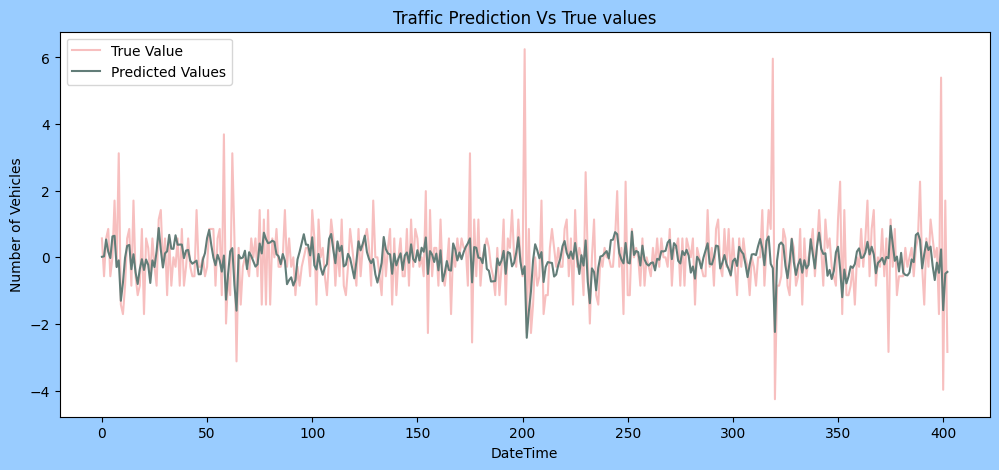


Best Model: GRU - RMSE: 0.9886384543937081



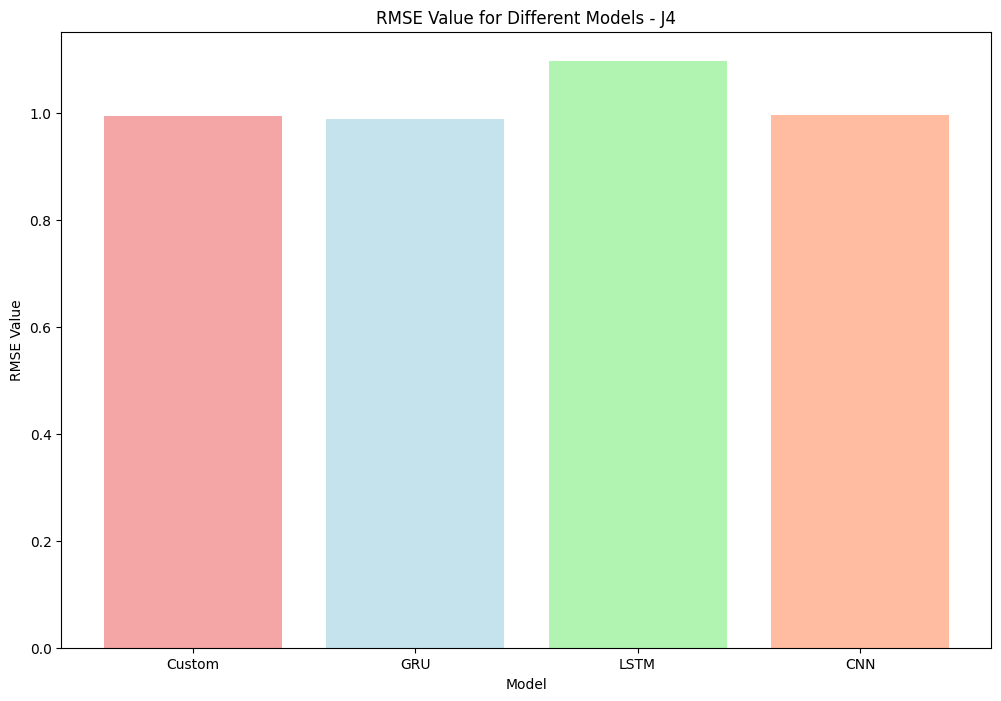

In [36]:
# Results for J4 - Custom Model
print("\033[1;31;2m########------Custom Model------########\033[0m")
RMSE_J4_Custom = RMSE_Value(y_testJ4, PredJ4_Custom)
PredictionsPlot(y_testJ4, PredJ4_Custom, 0)

# Results for J4 - GRU Model
print("\033[1;31;2m########------GRU Model------########\033[0m")
RMSE_J4_GRU = RMSE_Value(y_testJ4, PredJ4_GRU)
PredictionsPlot(y_testJ4, PredJ4_GRU, 0)

# Results for J4 - LSTM Model
print("\n\033[1;34;2m########------LSTM Model------########\033[0m")
RMSE_J4_LSTM = RMSE_Value(y_testJ4, PredJ4_LSTM)
PredictionsPlot(y_testJ4, PredJ4_LSTM, 0)

# Results for J4 - CNN Model
print("\n\033[1;32;2m########------CNN Model------########\033[0m")
RMSE_J4_CNN = RMSE_Value(y_testJ4, PredJ4_CNN)
PredictionsPlot(y_testJ4, PredJ4_CNN, 0)

# # Results for J4 - MLP Model
# print("\n\033[1;33;2m########------MLP Model------########\033[0m")
# RMSE_J4_MLP = RMSE_Value(y_testJ4, PredJ4_MLP)
# PredictionsPlot(y_testJ4, PredJ4_MLP, 0)

# Create a list of model names and their corresponding RMSE values
model_names = ["Custom", "GRU", "LSTM", "CNN"] #, "MLP"]
rmse_values = [RMSE_J4_Custom, RMSE_J4_GRU, RMSE_J4_LSTM, RMSE_J4_CNN] #, RMSE_J4_MLP]

model_rmse = list(zip(model_names, rmse_values))
Results_df = pd.DataFrame(model_rmse, columns=["MODEL", "RMSE"])
styled_df = Results_df.style.background_gradient(cmap="cool")

# Find the best model with the minimum RMSE value
best_model_index = rmse_values.index(min(rmse_values))
best_model_name_4 = model_names[best_model_index]
best_model_rmse_4 = rmse_values[best_model_index]

# Print the best model name and its RMSE value
print("\n\033[1;31;4mBest Model: {} - RMSE: {}\n".format(best_model_name_4, best_model_rmse_4))

# Plot the bar graph for model names and RMSE values with transparency and lighter colors
colors = ['lightcoral', 'lightblue', 'lightgreen', 'lightsalmon', 'lightyellow']
alpha = 0.7
fig, ax = plt.subplots(figsize=(12, 8))  # Set the figure size (width, height)
ax.bar(model_names, rmse_values, color=colors, alpha=alpha)
ax.set_xlabel('Model')
ax.set_ylabel('RMSE Value')
ax.set_title('RMSE Value for Different Models - J4')
plt.show()

display(styled_df)


In [37]:
#Initialise data of lists for error values of four junctions.
Junctions = ["Junction1", "Junction2", "Junction3", "Junction4"]
RMSE = [best_model_rmse_1, best_model_rmse_2, best_model_rmse_3, best_model_rmse_4]
Model = [best_model_name_1, best_model_name_2, best_model_name_3, best_model_name_4]
list_of_tuples = list(zip(Junctions, RMSE, Model))
# Creates pandas DataFrame.
Results = pd.DataFrame(list_of_tuples, columns=["Junction", "RMSE", "MODEL"])
Results.style.background_gradient(cmap="Pastel1")


##### Inversing the Transformations on the Data

In [38]:
# Functions to inverse transforms and Plot comparitive plots
# invert differenced forecast
def inverse_difference(last_ob, value):
    inversed = value + last_ob
    return inversed
#Plotting the comparison
def Sub_Plots2(df_1, df_2,title,m):
    fig, axes = plt.subplots(1, 2, figsize=(18,4), sharey=True,facecolor="#99ccff")
    fig.suptitle(title)

    pl_1=sns.lineplot(ax=axes[0],data=df_1,color=colors[m])
    axes[0].set(ylabel ="Prediction")

    pl_2=sns.lineplot(ax=axes[1],data=df_2["Vehicles"],color="#627D78")
    axes[1].set(ylabel ="Orignal")


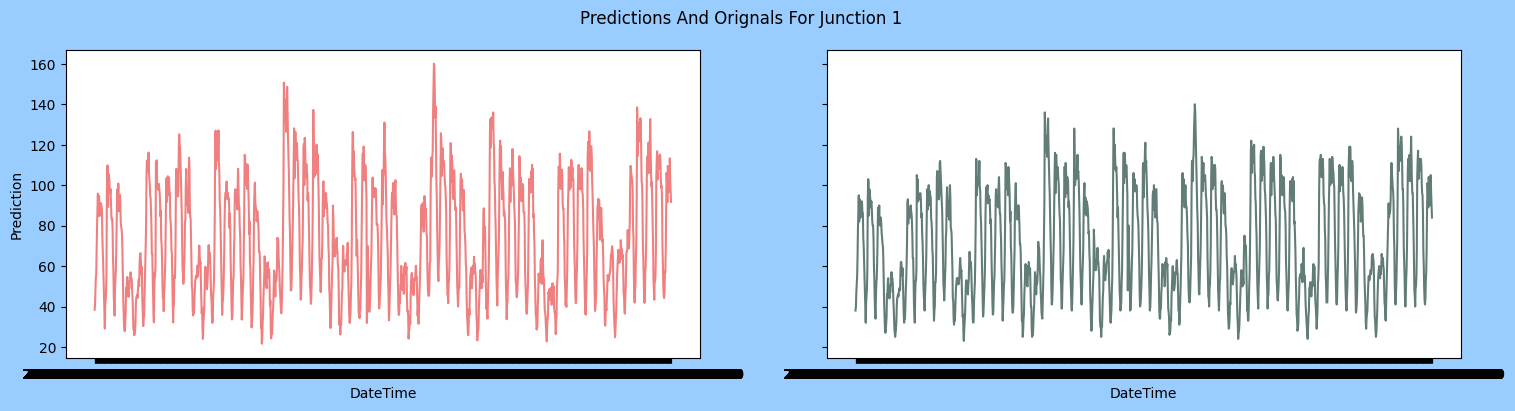

In [46]:
# invert the differenced forecast for Junction 1
recover1 = df1_normalized.Norms[-1412:-1].to_frame()
recover1["Pred"]= globals()[f"PredJ1_{Model[0]}"]
Transform_reverssed_J1 = inverse_difference(recover1.Norms, recover1.Pred).to_frame()
Transform_reverssed_J1.columns = ["Pred_Normed"]
#Invert the normalizeation J1
Final_J1_Pred = (Transform_reverssed_J1.values* df1_std) + df1_average
Transform_reverssed_J1["Pred_Final"] =Final_J1_Pred
#Plotting the Predictions with orignals
Sub_Plots2(Transform_reverssed_J1["Pred_Final"], df_1[-1412:-1],"Predictions And Orignals For Junction 1", 0)


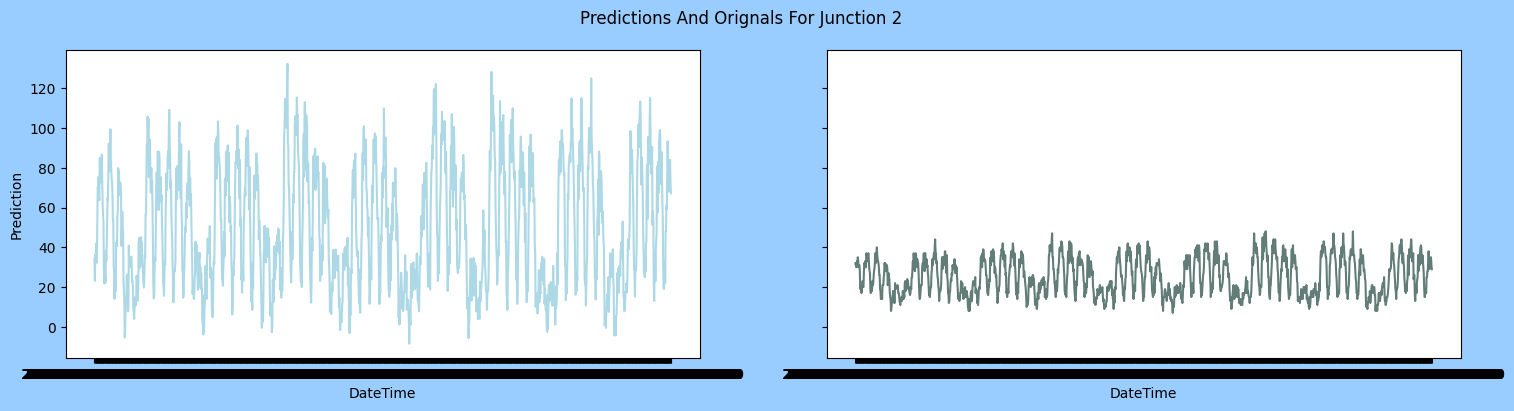

In [47]:
#Invert the differenced J2
recover2 = df2_normalized.Norms[-1412:-1].to_frame() #len as per the diff
recover2["Pred"]= globals()[f"PredJ2_{Model[1]}"]
Transform_reverssed_J2 = inverse_difference(recover2.Norms, recover2.Pred).to_frame()
Transform_reverssed_J2.columns = ["Pred_Normed"]
Final_J2_Pred = (Transform_reverssed_J2.values* df1_std) + df2_average
Transform_reverssed_J2["Pred_Final"] =Final_J2_Pred
#Plotting the Predictions with orignals
Sub_Plots2(Transform_reverssed_J2["Pred_Final"], df_2[-1426:-1],"Predictions And Orignals For Junction 2", 1)


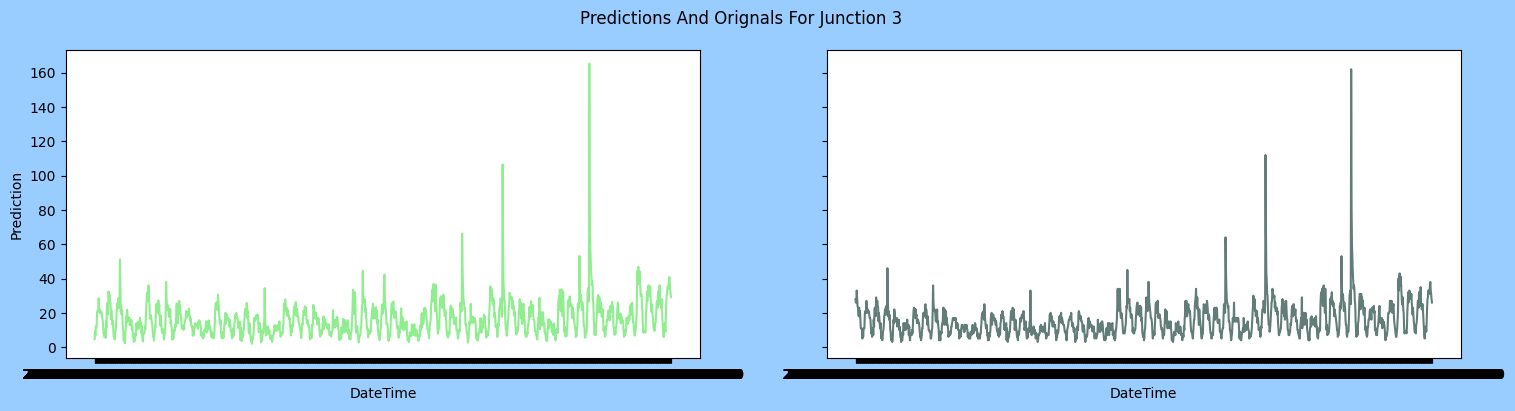

In [48]:
#Invert the differenced J3
recover3 = df3_normalized.Norms[-1412:-1].to_frame() #len as per the diff
recover3["Pred"]= globals()[f"PredJ3_{Model[2]}"]
Transform_reverssed_J3 = inverse_difference(recover3.Norms, recover3.Pred).to_frame()
Transform_reverssed_J3.columns = ["Pred_Normed"]
#Invert the normalizeation J3
Final_J3_Pred = (Transform_reverssed_J3.values* df3_std) + df3_average
Transform_reverssed_J3["Pred_Final"] =Final_J3_Pred
Sub_Plots2(Transform_reverssed_J3["Pred_Final"], df_3[-1429:-1],"Predictions And Orignals For Junction 3", 2)


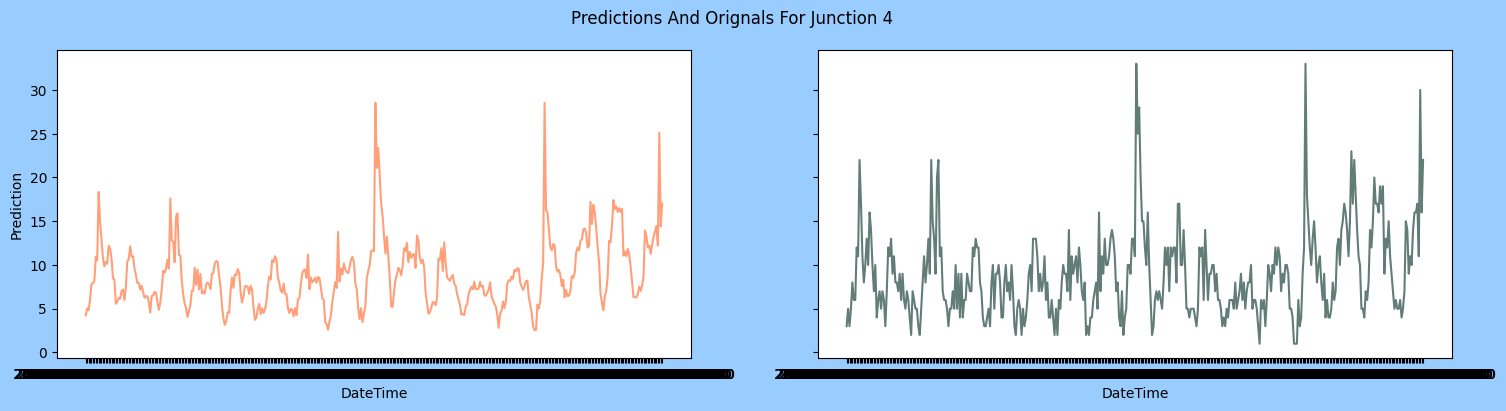

In [49]:
#Invert the differenced J4
recover4 = df4_normalized.Norms[-404:-1].to_frame()  #len as per the testset
recover4["Pred"]= globals()[f"PredJ4_{Model[3]}"]
Transform_reverssed_J4 = inverse_difference(recover4.Norms, recover4.Pred).to_frame()
Transform_reverssed_J4.columns = ["Pred_Normed"]
#Invert the normalizeation J4
Final_J4_Pred = (Transform_reverssed_J4.values* df4_std) + df4_average
Transform_reverssed_J4["Pred_Final"] =Final_J4_Pred
Sub_Plots2(Transform_reverssed_J4["Pred_Final"], df_4[-404:-1],"Predictions And Orignals For Junction 4", 3)
